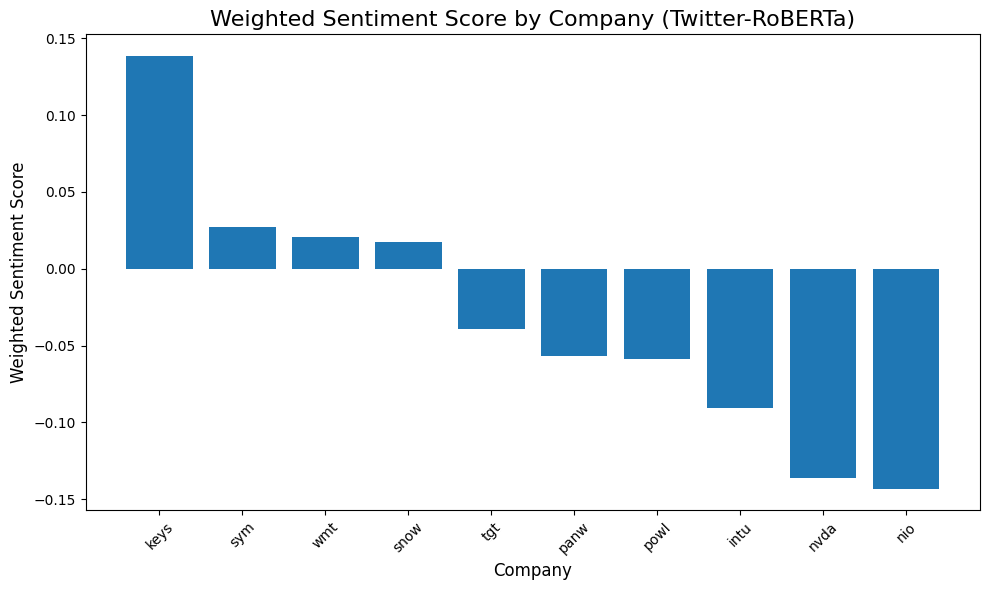

In [30]:
# using ROBERT for reddit data
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from matplotlib import pyplot as plt

# Load the dataset
data = pd.read_csv('/content/combined_reddit.csv')

# Load Twitter-RoBERTa model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function for sentiment analysis using Twitter-RoBERTa
def predict_roberta_sentiment(comment):
    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probabilities = softmax(outputs.logits, dim=-1).detach().numpy()[0]
    sentiment_score = probabilities[2] - probabilities[0]  # Positive - Negative
    return sentiment_score

# Apply Twitter-RoBERTa sentiment analysis
data['RobertaSentiment'] = data['comment'].apply(predict_roberta_sentiment)

# Weight the sentiment score by the comment score
data['WeightedSentiment'] = data['RobertaSentiment'] * data['score']

# Group by company and calculate the weighted average sentiment score using `agg`
company_sentiment = data.groupby('company').agg(
    WeightedSentimentSum=('WeightedSentiment', 'sum'),
    ScoreSum=('score', 'sum')
).reset_index()

# Avoid division by zero and calculate the weighted average sentiment
company_sentiment['WeightedSentiment'] = company_sentiment.apply(
    lambda row: row['WeightedSentimentSum'] / row['ScoreSum'] if row['ScoreSum'] != 0 else 0,
    axis=1
)

# Keep only the necessary columns
company_sentiment = company_sentiment[['company', 'WeightedSentiment']]

# Sort by sentiment score for better visualization
company_sentiment = company_sentiment.sort_values(by='WeightedSentiment', ascending=False)

# Plot sentiment by company as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(company_sentiment['company'], company_sentiment['WeightedSentiment'])
plt.title('Weighted Sentiment Score by Company (Twitter-RoBERTa)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Weighted Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Average Sentiment Score by Company:
     Company  Sentiment
8   news_tgt   0.216770
9   news_wmt   0.168553
3  news_nvda   0.054734
6  news_snow  -0.297055
1  news_keys  -0.371401
0  news_intu  -0.460091
2   news_nio  -0.559569
5  news_powl  -0.633592
7   news_sym  -0.666591
4  news_panw  -0.686466


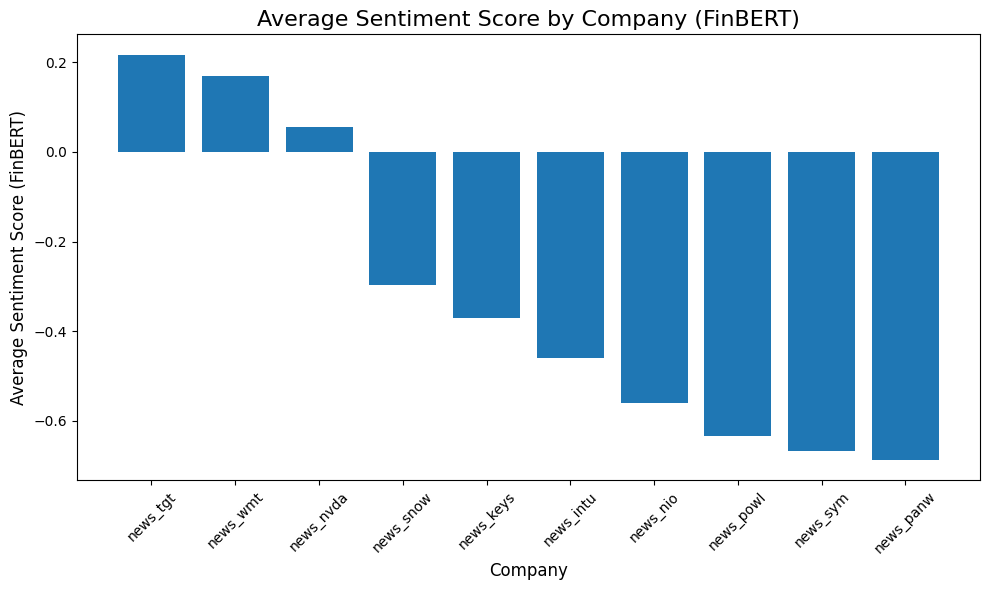

In [31]:
# using FinBERT for newsdata
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from matplotlib import pyplot as plt

# Load the news dataset
news_data = pd.read_csv('/content/combine_news.csv')

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function for sentiment analysis using FinBERT
def predict_finbert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probabilities = softmax(outputs.logits, dim=-1).detach().numpy()[0]
    sentiment_score = probabilities[2] - probabilities[0]  # Positive - Negative
    return sentiment_score

# Apply FinBERT sentiment analysis to the 'Title' column
news_data['Sentiment'] = news_data['Title'].apply(predict_finbert_sentiment)

# Group by company and calculate the average sentiment score
company_sentiment = news_data.groupby('Company')['Sentiment'].mean().reset_index()

# Sort by sentiment score for better visualization
company_sentiment = company_sentiment.sort_values(by='Sentiment', ascending=False)
# Display the grouped sentiment scores
print("Average Sentiment Score by Company:")
print(company_sentiment)

# Plot sentiment by company as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(company_sentiment['Company'], company_sentiment['Sentiment'])
plt.title('Average Sentiment Score by Company (FinBERT)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Average Sentiment Score (FinBERT)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Analyzing sentiment using Twitter-RoBERTa...
Analyzing sentiment using VADER...
Calculating weighted average sentiment scores by company...
Generating sentiment visualization...


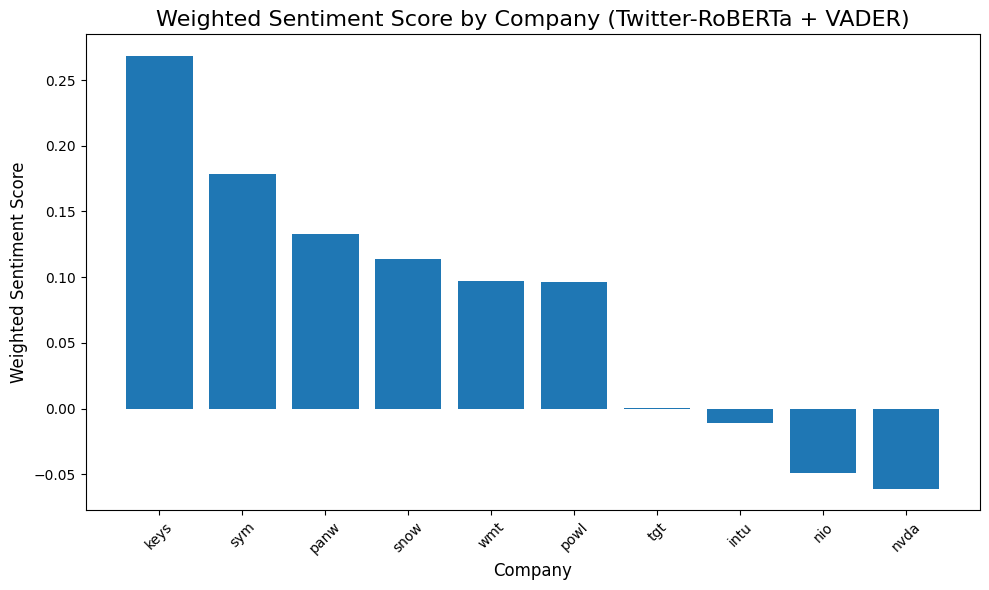

In [34]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from matplotlib import pyplot as plt

# Ensure VADER lexicon is available
try:
    sid = SentimentIntensityAnalyzer()
except:
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()

# Load the dataset
data = pd.read_csv('/content/combined_reddit.csv')

# Load Twitter-RoBERTa model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function for sentiment analysis using Twitter-RoBERTa
def predict_roberta_sentiment(comment):
    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    probabilities = softmax(outputs.logits, dim=-1).detach().numpy()[0]
    sentiment_score = probabilities[2] - probabilities[0]  # Positive - Negative
    return sentiment_score

# Function for sentiment analysis using VADER
def predict_vader_sentiment(comment):
    return sid.polarity_scores(comment)['compound']

# Apply Twitter-RoBERTa sentiment analysis
print("Analyzing sentiment using Twitter-RoBERTa...")
data['RobertaSentiment'] = data['comment'].apply(predict_roberta_sentiment)

# Apply VADER sentiment analysis
print("Analyzing sentiment using VADER...")
data['VaderSentiment'] = data['comment'].apply(predict_vader_sentiment)

# Combine the two sentiment scores
data['CombinedSentiment'] = (0.7 * data['RobertaSentiment']) + (0.3 * data['VaderSentiment'])

# Weight the sentiment score by the comment score
data['WeightedSentiment'] = data['CombinedSentiment'] * data['score']

# Group by company and calculate the weighted average sentiment score
print("Calculating weighted average sentiment scores by company...")
company_sentiment = data.groupby('company', group_keys=False).apply(
    lambda x: pd.Series({'WeightedSentiment': x['WeightedSentiment'].sum() / x['score'].sum() if x['score'].sum() != 0 else 0}),
    include_groups=False
).reset_index()

# Sort by sentiment score for better visualization
company_sentiment = company_sentiment.sort_values(by='WeightedSentiment', ascending=False)

# Plot sentiment by company as a bar chart
print("Generating sentiment visualization...")
plt.figure(figsize=(10, 6))
plt.bar(company_sentiment['company'], company_sentiment['WeightedSentiment'])
plt.title('Weighted Sentiment Score by Company (Twitter-RoBERTa + VADER)', fontsize=16)
plt.xlabel('Company', fontsize=12)
plt.ylabel('Weighted Sentiment Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
